#### This notebook will read in Scott England's observation file taken from a TIME-GCM (I think) run, and create a L1 data file in UIUC format. A separate notebook will take this L1 file and turn it into a L2.1 file.

# This copy is a temporary test, using some of Kenn's variables

Certain functions in this file may also be useful for the file from Vicki

What is contained in L1 UIUC file:
- ???


In [16]:
%pylab inline
from Scientific.IO.NetCDF import NetCDFFile as Dataset
from datetime import datetime, timedelta
from pyglow import pyglow
from mpl_toolkits.basemap import Basemap
import os
import glob
from scipy.interpolate import griddata
import subprocess
import MIGHTI

reload(MIGHTI)

# Make default figure size bigger
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
#ncfn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20151122/England_raw/ICON_MIGHTI_A_ray_UT_1005.00.nc'
ncfn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20151122/England_raw/ICON_MIGHTI_B_ray_UT_1080.00.nc'

########## LOAD CONSTANTS/PARAMETERS ##########
emission_color = 'red' # 'red' or 'green'
day = True

emissions =  MIGHTI.get_emission_constants()
params = MIGHTI.get_instrument_constants()

params['exptime'] =        60.   # sec
params['lam'] =            emissions[emission_color]['lam']
params['frq'] =            emissions[emission_color]['frq']
params['mass'] =           emissions[emission_color]['mass']
if day: # 10% reduction in aperture size during "day", and shorter exposure time
    params['aperture_area'] =  params['aperture_area'] * 0.1
    params['exptime'] =        30.
plot_color = emission_color[0]

j = 1 # Use middle column only, so as not to care about horizontal resolution.

# Whether to include the fact that in the near and far field,
# the line of sight is not horizontal. Set this to True in order
# to run a non-physical simulation to test the inversion. For
# realistic simulations, this should be False.
UNDO_LOCAL_HORZ_PROJECTION = False 
# Whether to include Earth rotation in the forward model. Set this to 
# True to run a non-physical simulation to test the inversion. For
# realistic simulations, this should be False.
UNDO_EARTH_ROTATION = False
###############################################


ncfile = Dataset(ncfn,'r')
vs = ncfile.variables.keys()
vs.sort()
#vs

In [18]:
ray_length = ncfile.variables['MIGHTI_RAY_LENGTH_KM'][0]
emission_along_ray_r = ncfile.variables['MIGHTI_%sLINE_ALONG_RAY_R' % emission_color.upper()][0,:,:,:]
winds_along_ray = ncfile.variables['MIGHTI_LOS_WINDS_ALONG_RAY'][0,:,:,:]
temps_along_ray = ncfile.variables['MIGHTI_TEMPERATURES_ALONG_RAY'][0,:,:,:]
alts_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]
alts_along_ray_end = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_END'][0,:,:,:]
tang_point_along_ray_start = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_START'][0,:,:] # integer index
tang_point_along_ray_end  = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_END'][0,:,:] # integer index
tang_alt_start = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_START'][0,:,:]
tang_alt_end = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_END'][0,:,:]
tang_lat_start = ncfile.variables['MIGHTI_TANGENT_LATITUDES_START'][0,:,:]
tang_lat_end = ncfile.variables['MIGHTI_TANGENT_LATITUDES_END'][0,:,:]
tang_lon_start = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_START'][0,:,:]
tang_lon_end = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_END'][0,:,:]
#icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,0,0,0]
#icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,0,0,0]
icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,]
icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,]
icon_lat_start = ncfile.variables['ICON_LATITUDE_START'][0,] 
icon_lat_end = ncfile.variables['ICON_LATITUDE_END'][0,] 
icon_lon_start = ncfile.variables['ICON_LONGITUDE_START'][0,]
icon_lon_end = ncfile.variables['ICON_LONGITUDE_END'][0,] 
icon_ecef_ram_vector_start = ncfile.variables['ICON_ECEF_RAM_VECTOR_START'][0,:]
icon_ecef_ram_vector_end = ncfile.variables['ICON_ECEF_RAM_VECTOR_END'][0,:]
icon_velocity_start = ncfile.variables['ICON_VELOCITY_START'][0]*1000 # convert from km/s to m/s
icon_velocity_end = ncfile.variables['ICON_VELOCITY_END'][0]*1000 # convert from km/s to m/s
mighti_sza = ncfile.variables['MIGHTI_SZA'][0,:,:,:] # 1000 x 101 x 3

mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
mighti_ecef_vectors_end = ncfile.variables['MIGHTI_ECEF_VECTORS_END'][0,:,:,:]
mighti_horizontal_component = ncfile.variables['MIGHTI_HORIZONTAL_COMPONENT'][0,:,:,:]
mighti_corotation_vel = ncfile.variables['MIGHTI_COROTATION_VEL'][0,:,:,:]
# Hack to fix a nan issue
mighti_horizontal_component[isnan(mighti_horizontal_component)] = 1.0 # shouldn't make a difference


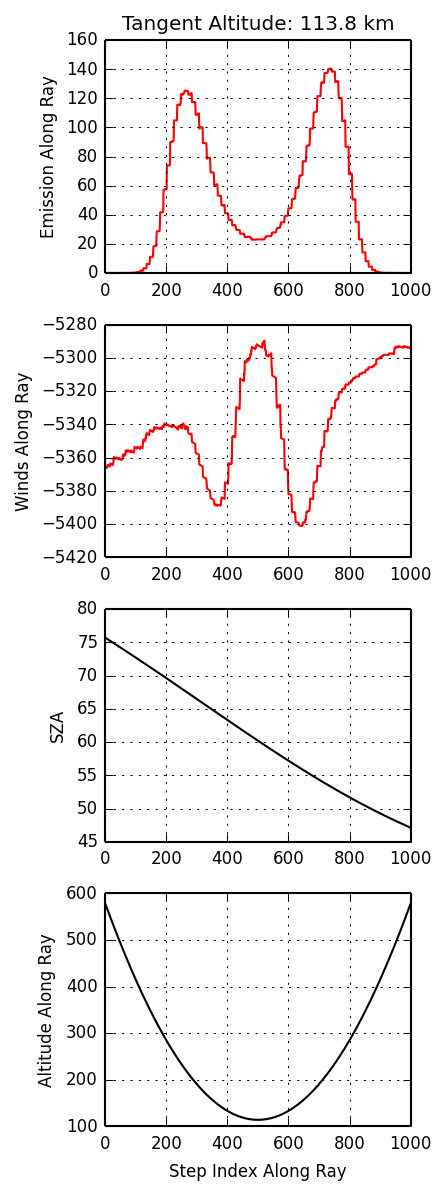

In [19]:
i = 8
j = 1
figure(figsize=(3,8))
subplot(4,1,1)
plot(emission_along_ray_r[:,i,j],'r')
ylabel('Emission Along Ray')
title('Tangent Altitude: %.1f km' % tang_alt_start[i,j])
grid()
subplot(4,1,2)
plot(winds_along_ray[:,i,j],'r')
ylabel('Winds Along Ray')
grid()
subplot(4,1,3)
plot(mighti_sza[:,i,j]*180/pi,'k-')
ylabel('SZA')
grid()
subplot(4,1,4)
plot(alts_along_ray_start[:,i,j],'k')
ylabel('Altitude Along Ray')
xlabel('Step Index Along Ray')
grid()
tight_layout()
#savefig('/home/bhardin2/public_html/parameters_along_ray.png',dpi=200)

## Generate interferogram

In [20]:
nx = params['nx']
ny = shape(winds_along_ray)[1] # number of rows of interferogram
nk = shape(winds_along_ray)[0] # number of steps along ray

tang_alts = tang_alt_start[:,j]

Iraw = np.zeros((ny,nx))

for i in range(ny):
    for k in range(nk):

        amp = emission_along_ray_r[k,i,j]
        vel = winds_along_ray[k,i,j]
        temp = temps_along_ray[k,i,j]
        if UNDO_LOCAL_HORZ_PROJECTION:
            # Take out satellite velocity, then undo
            # horz projection, then put it back in
            look_ecef = (mighti_ecef_vectors_start[i,j,:]+mighti_ecef_vectors_end[i,j,:])/2
            icon_velocity = (icon_velocity_start + icon_velocity_end)/2
            icon_ecef_ram_vector = (icon_ecef_ram_vector_start + icon_ecef_ram_vector_end)/2
            proj_icon_vel = icon_velocity * np.dot(look_ecef,icon_ecef_ram_vector)
            wvel = vel - proj_icon_vel
            wvel = wvel/mighti_horizontal_component[k,i,j]
            vel = wvel + proj_icon_vel
            if isnan(vel):
                raise Exception('%i, %i, %i' % (i,j,k))
        if UNDO_EARTH_ROTATION:
            vel = vel - mighti_corotation_vel[k,i,j]
            
        alt = alts_along_ray_start[k,i,j]

        params['V'] = vel
        params['T'] = temp
        params['I'] = amp

        ccdslice = MIGHTI.interferogram(params)

        Iraw[i,:] += ccdslice
        


<matplotlib.colorbar.Colorbar instance at 0x7fcbfc9845f0>

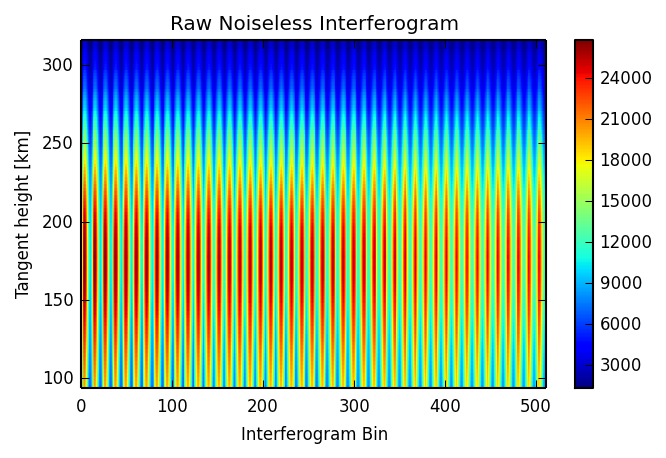

In [21]:
figure(figsize=(5,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Iraw,cmap='jet')
axis('tight')
xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('Raw Noiseless Interferogram')
colorbar()

# Ok, but we're not going to use that. We're going to use Kenn's instead.

In [22]:
from Scientific.IO.NetCDF import NetCDFFile as Dataset

marrncfile = Dataset('/home/bhardin2/MIGHTI/Englandfiles/AB_20151123/ICON_MIGHTI_B_ray_UT_1080.00.nc','r')

In [25]:
Imarr = marrncfile.variables['RED_ARRAY_NOISELESS'].getValue()

<matplotlib.colorbar.Colorbar instance at 0x7fcbfc7cba70>

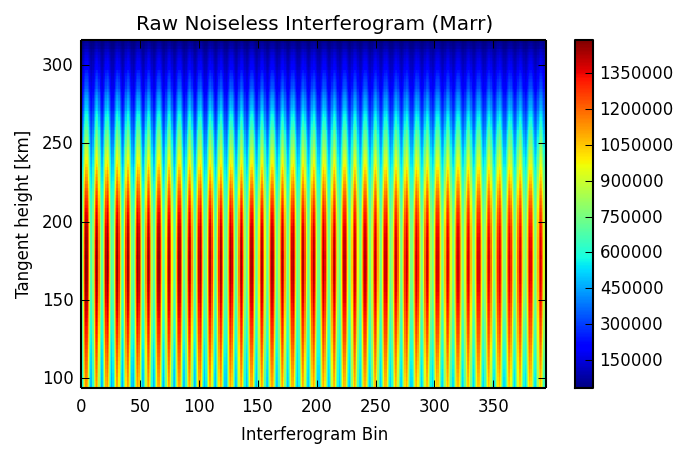

In [30]:
figure(figsize=(5,3))
ny,nx = shape(Imarr)
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Imarr,cmap='jet')
axis('tight')
xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('Raw Noiseless Interferogram (Marr)')
colorbar()

In [31]:
Iraw = Imarr # Overwrite Iraw with Kenn's value

# Add Noise (skipped for now)

In [32]:
#Inoisy = MIGHTI.add_noise(Iraw, params) # make sure units are right
Inoisy = Iraw.copy()

## L1 processing

In [33]:
Ir = zeros(shape(Inoisy))
Ii = zeros(shape(Inoisy))
for i in range(shape(Inoisy)[0]):
    # Filter with Hann window (in frequency) surrounding the peak
    f = Inoisy[i,:]
    F = np.fft.fft(f)
    N = len(F)
    n = arange(N)
    # Create filter as per Ken Marr's email 2013/10/29
    peaki = abs(F[5:floor(N/2)]).argmax() + 5
    width1 = 20 # width of Hann window
    width2 = 5 # width of plateau
    hann = np.hanning(width1)
    # Create full filter
    H = hstack((zeros(peaki-width1/2-(width2-1)/2), 
                hann[:width1/2], 
                ones(width2), 
                hann[width1/2:], 
                zeros(N - peaki - width1/2 - (width2-1)/2 - 1)))
    ap = hanning(N)
    f = f - f.mean()
    fap = f*ap
    F = np.fft.fft(fap)
    F2 = F * H
    f2 = np.fft.ifft(F2)
    Ir[i,:] = np.real(f2)
    Ii[i,:] = np.imag(f2)

<matplotlib.colorbar.Colorbar instance at 0x7fcbfc841f80>

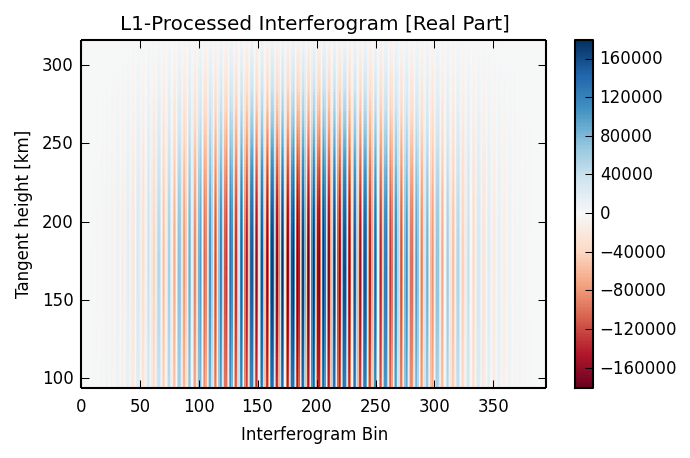

In [34]:
figure(figsize=(5,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Ir,cmap='RdBu')
axis('tight')

xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('L1-Processed Interferogram [Real Part]')
colorbar()

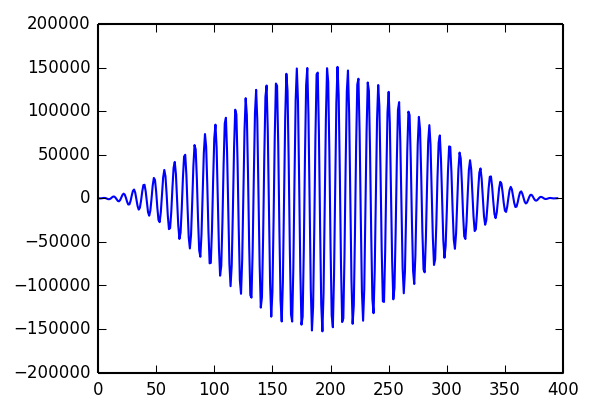

In [35]:
plot(Ir[50,:])

In [36]:
# Save L1 UIUC file
icon_alt = (icon_alt_start + icon_alt_end)/2
L1_UIUC_fn = '/home/bhardin2/MIGHTI/MIGHTI_L1_UIUC_%s_001.npz' % emission_color
np.savez(L1_UIUC_fn,
         Ir=Ir, 
         Ii=Ii, 
         tang_alt_start=  tang_alt_start[:,j],
         tang_alt_end  =  tang_alt_end[:,j],
         tang_lat_start=  tang_lat_start[:,j],
         tang_lat_end  =  tang_lat_end[:,j],
         tang_lon_start=  tang_lon_start[:,j],
         tang_lon_end  =  tang_lon_end[:,j],
         emission_color=  emission_color,
         icon_alt_start=  icon_alt_start,
         icon_alt_end=    icon_alt_end,
         icon_lat_start=  icon_lat_start,
         icon_lat_end=    icon_lat_end,
         icon_lon_start=  icon_lon_start,
         icon_lon_end=    icon_lon_end,
         mighti_ecef_vectors_start=  mighti_ecef_vectors_start[:,j,:],
         mighti_ecef_vectors_end=    mighti_ecef_vectors_end[:,j,:],
         icon_ecef_ram_vector_start= icon_ecef_ram_vector_start,
         icon_ecef_ram_vector_end=   icon_ecef_ram_vector_end,
         icon_velocity_start=        icon_velocity_start,
         icon_velocity_end=          icon_velocity_end,
         datetime_created=           datetime.now(),
         source_files =              [ncfn],
         time         =              0,
         interferometer_start_path = params['startpath'],
         interferometer_end_path =   params['endpath'],)
print L1_UIUC_fn

/home/bhardin2/MIGHTI/MIGHTI_L1_UIUC_red_001.npz


### Obtain truth los winds and save to separate file

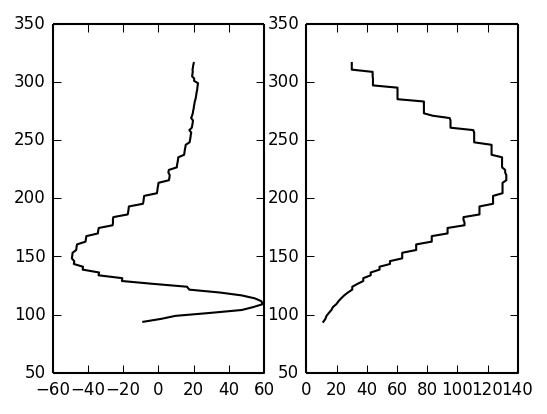

In [37]:
truth_fn = '/home/bhardin2/MIGHTI/truth_winds_001.npz'

# Remove satellite velocity from LoS winds provided
tang_alts = (tang_alt_start[:,j] + tang_alt_end[:,j])/2
mighti_ecef_vectors = (mighti_ecef_vectors_start[:,j,:] + mighti_ecef_vectors_end[:,j,:])/2 # ny by 3
icon_velocity = (icon_velocity_start + icon_velocity_end)/2
icon_ecef_ram_vector = (icon_ecef_ram_vector_start + icon_ecef_ram_vector_end)/2

# Create a column vector with projected satellite velocity. 
# Remember, we are ignoring horizontal extent for now.
proj_icon_vel = zeros(ny)
for i in range(ny):
    look_ecef = mighti_ecef_vectors[i,:] # look direction of this pixel in ECEF
    proj_icon_vel[i] = icon_velocity * np.dot(icon_ecef_ram_vector, look_ecef)


    
truth_winds = zeros(ny)
truth_amps = zeros(ny)
for i in range(ny):
    kstar = tang_point_along_ray_start[i,j]
    truth_winds[i] = winds_along_ray[kstar,i,j] - proj_icon_vel[i]
    truth_winds[i] = truth_winds[i] - mighti_corotation_vel[kstar,i,j]
    truth_amps[i] = emission_along_ray_r[kstar,i,j]
subplot(1,2,1)
plot(truth_winds,tang_alts,'k')
subplot(1,2,2)
plot(truth_amps,tang_alts,'k')


np.savez(truth_fn,tang_alts=tang_alts,truth_winds=truth_winds,\
         truth_amps=truth_amps)
